# Postcovid dataset preprocessing

## Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
from data_utils.preprocessing_utilities import stat_unique,get_modalities_nb, remove_duplicates, densify,create_q2k, encode_attr, quadruplet_format, parse_data, split_data, save_to_csv,get_metadata, split_data_vertically,rescaling_dict,one_hot_encoding

import json
import torch
import pandas as pd
import numpy as np

In [3]:
raw_data = pd.read_csv('preprocessed_postcovid_30-01-2024.csv', encoding="ISO-8859-15", low_memory=False)
raw_data = raw_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2', 'UX_answer', 'result', 'answers', 'itemnaireId',
                                  'start_time', 'userIdAndCreationDate', 'qr', 'qr_compl'])
raw_data =  raw_data.rename(columns={"skill_id": "dimension_id", "item_id":"item_id"})
raw_data.head()

,dimension_id,user_id,item_id,correct
0,{9},0,3,1.0
1,{9},0,12,3.0
2,{9},0,20,2.0
3,{9},0,27,3.0
4,{9},0,34,1.0


In [4]:
raw_data['dimension_id'] = raw_data['dimension_id'].str.strip('{}').str.split(',')
raw_data = raw_data.explode('dimension_id')
raw_data['dimension_id'] = raw_data['dimension_id'].str.strip()

In [5]:
stat_unique(raw_data, None)
stat_unique(raw_data, ['user_id', 'item_id'])
stat_unique(raw_data, 'user_id')
stat_unique(raw_data, 'item_id')
stat_unique(raw_data, 'dimension_id')

Total length: 51690
Number of unique [user_id,item_id]: 37390
Number of unique user_id: 917
Number of unique item_id: 184
Number of unique dimension_id: 18


## Clean Nan values

In [6]:
cleaned_data = raw_data.dropna(subset=['user_id','item_id','dimension_id','correct'], axis='index')

In [7]:
cleaned_data

,dimension_id,user_id,item_id,correct
0,9,0,3,1.0
1,9,0,12,3.0
2,9,0,20,2.0
3,9,0,27,3.0
4,9,0,34,1.0
...,...,...,...,...
37385,3,916,158,1.0
37386,5,916,163,6.0
37387,3,916,170,2.0
37388,5,916,174,6.0


## Remove duplicated user and id rows

In [8]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

## Filter data

In [9]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0

while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0: 
    # filter knowledges
    filtered_data_1,filtered_d_nb = densify(filtered_data_0,'dimension_id','item_id',5)
    
    # aggregate
    agg_data_0 = filtered_data_1
    agg_data_0['dimension_id'] = agg_data_0['dimension_id'].str.strip('{}')
    grouped_data = agg_data_0.groupby(['user_id', 'item_id'])['dimension_id'] \
        .apply(lambda x: '{' + ', '.join(x) + '}') \
        .reset_index()
    agg_data_0 = agg_data_0.drop(columns=['dimension_id']).drop_duplicates(subset=['user_id', 'item_id'])
    agg_data_0 = pd.merge(agg_data_0, grouped_data, on=['user_id', 'item_id'], how='left')
    
    # filter items
    filtered_data_2,filtered_q_nb = densify(agg_data_0,'item_id','user_id',20)
    
    # filter users
    filtered_data_3,filtered_u_nb = densify(filtered_data_2,'user_id','item_id',20)
    
    # split
    split_0 = filtered_data_3
    split_0.loc[:,'dimension_id'] = split_0['dimension_id'].str.strip('{}').str.split(',')
    split_0 = split_0.explode('dimension_id')
    split_0['dimension_id'] = split_0['dimension_id'].str.strip()
    
    # update the dataset for potential next iteration
    filtered_data_0 = split_0
    
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 1 dimension_id


/tmp/ipykernel_20626/2255379976.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_data_0['dimension_id'] = agg_data_0['dimension_id'].str.strip('{}')


filter 0 item_id
filter 171 user_id
filter 0 dimension_id
filter 0 item_id
filter 0 user_id
Total length: 48583
Number of unique [user_id,item_id]: 34563
Number of unique user_id: 746
Number of unique item_id: 180
Number of unique dimension_id: 17


## Encoding

In [10]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [11]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [12]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

## Maps creation

In [13]:
q2k, k2q = create_q2k(d_enc_data)

## Rescaling responses

In [14]:
d_enc_data['correct'] = d_enc_data['correct'].astype(float)

min_val = d_enc_data.groupby('item_id')['correct'].transform('min')
max_val = d_enc_data.groupby('item_id')['correct'].transform('max')

# Rescale 'correct' values per 'item_id'
d_enc_data['correct'] = (d_enc_data['correct'] - min_val) / (max_val - min_val) + 1

# Assign the rescaled data to 'rescaled_data'
rescaled_data = d_enc_data
print(f'min value : {rescaled_data.groupby("item_id")["correct"].min()}, max value : {rescaled_data.groupby("item_id")["correct"].max()}')

min value : item_id
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
175    1.0
176    1.0
177    1.0
178    1.0
179    1.0
Name: correct, Length: 180, dtype: float64, max value : item_id
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
175    2.0
176    2.0
177    2.0
178    2.0
179    2.0
Name: correct, Length: 180, dtype: float64


## Get final stats and create metadata

In [15]:
stat_unique(rescaled_data, None)
stat_unique(rescaled_data, ['user_id', 'item_id'])
stat_unique(rescaled_data, 'user_id')
stat_unique(rescaled_data, 'item_id')
stat_unique(rescaled_data, 'dimension_id')
stat_unique(rescaled_data, 'correct')

rescaled_data_dim_grouped_items = rescaled_data.groupby("dimension_id")["item_id"].nunique()
rescaled_data_dim_grouped_users = rescaled_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(rescaled_data_dim_grouped_items),int(np.round(np.mean(rescaled_data_dim_grouped_items))),np.max(rescaled_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(rescaled_data_dim_grouped_users),int(np.round(np.mean(rescaled_data_dim_grouped_users))),np.max(rescaled_data_dim_grouped_users)))

rescaled_data_dim_grouped_items = rescaled_data.groupby("item_id")["dimension_id"].nunique()
rescaled_data_dim_grouped_users = rescaled_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(rescaled_data_dim_grouped_items),int(np.round(np.mean(rescaled_data_dim_grouped_items))),np.max(rescaled_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(rescaled_data_dim_grouped_users),int(np.round(np.mean(rescaled_data_dim_grouped_users))),np.max(rescaled_data_dim_grouped_users)))

rescaled_data_dim_grouped_items = rescaled_data.groupby("user_id")["item_id"].nunique()
rescaled_data_dim_grouped_users = rescaled_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(rescaled_data_dim_grouped_items),int(np.round(np.mean(rescaled_data_dim_grouped_items))),np.max(rescaled_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(rescaled_data_dim_grouped_users),int(np.round(np.mean(rescaled_data_dim_grouped_users))),np.max(rescaled_data_dim_grouped_users)))

Total length: 48583
Number of unique [user_id,item_id]: 34563
Number of unique user_id: 746
Number of unique item_id: 180
Number of unique dimension_id: 17
Number of unique correct: 22
#questions/category: 7 & 14 &  22
#users/category: 38 & 206 &  460
#categorys/question: 1 & 1 &  3
#users/question: 38 & 192 &  460
#questions/users: 20 & 46 &  92
#categorys/users: 1 & 5 &  10


Text(0.5, 1.0, 'Distribution of Responses')

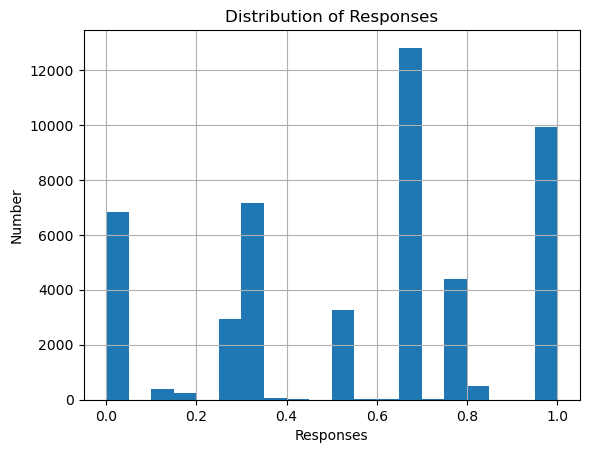

In [16]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(rescaled_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')


In [17]:
metadata = get_metadata(rescaled_data,["user_id", "item_id", "dimension_id"])

## Compute nb of modalities

## Compute number of modalities

In [18]:
nb_modalities = get_modalities_nb(rescaled_data, metadata)

### Save data, concept map, metadata and nb of modalities

In [19]:
# save selected data
rescaled_data.to_csv('selected_data.csv', index=False)

In [20]:
# Convert int64 keys to a compatible type (e.g., int)
q2k_serializable = {str(key): value for key, value in q2k.items()}
# save concept map
with open('concept_map.json', 'w') as f:
    json.dump(q2k_serializable, f)

In [21]:
# save metadata
with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

In [22]:
# save nb_modalities
import torch
torch.save(nb_modalities,'nb_modalities.pkl')

## Parse data

In [23]:
quadruplet = quadruplet_format(rescaled_data)

In [24]:
stu_data, ques_data = parse_data(rescaled_data)

In [25]:
test_size = 0.2
valid_size = 0.2 # proportion over the all dataset
least_test_length=18

In [ ]:
## Vertical split

In [27]:
train_data, valid_data, test_data = split_data_vertically(quadruplet, test_prop=test_size,valid_prop=valid_size, folds_nb=5)

In [29]:
for i_fold, train_fold in enumerate(train_data):
    save_to_csv(train_data[i_fold], f'../2-preprocessed_data/postcovid_train_quadruples_vert_{i_fold}.csv')
    save_to_csv(valid_data[i_fold], f'../2-preprocessed_data/postcovid_valid_quadruples_vert_{i_fold}.csv')
    save_to_csv(test_data[i_fold], f'../2-preprocessed_data/postcovid_test_quadruples_vert_{i_fold}.csv')